In [2]:
pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     -------------------------------------- 200.5/200.5 kB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
np.__version__

'1.20.1'

In [3]:
from hyperopt import hp
search_space = {'x':hp.quniform('x',-10,10,1), 'y':hp.quniform('y',-15,15,1)}

In [4]:
from hyperopt import STATUS_OK

def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  retval = x*2 - 20*y
  
  return retval

In [5]:
from hyperopt import fmin, tpe, Trials
import numpy as np

trial_val = Trials()

best_01 = fmin(fn=objective_func, space=search_space,algo=tpe.suggest,
               max_evals=5, trials=trial_val, rstate=np.random.default_rng(seed=0))

print('best:',best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 290.44trial/s, best loss: -248.0]
best: {'x': -4.0, 'y': 12.0}


In [8]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func,    ## 목적 함수
               space=search_space,   ## 검색 공간
               algo=tpe.suggest,     ## 베이지안 최적화 적용 알고리즘 (기본 파라미터 tpe.suggest)
               max_evals=20,         ## 입력 시도 횟수
               trials=trial_val,     ## 시도한 입력 값 및 입력 결과 저장
               rstate=np.random.default_rng(seed=0)   ## fmin()을 시도할 때마다 동일한 결과를 가질 수 있도록 설정하는 랜덤 시드
               )
print('best:', best_02)

100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 393.22trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [9]:
#fmin()에 인자로 들어가는 trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
#리스트 내부의 개별 원소는 {'loss':함수반환값,'status':반환 상태값} 형태의 딕셔너리

print(trial_val.results)

[{'loss': -112.0, 'status': 'ok'}, {'loss': -208.0, 'status': 'ok'}, {'loss': 48.0, 'status': 'ok'}, {'loss': -248.0, 'status': 'ok'}, {'loss': -2.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -120.0, 'status': 'ok'}, {'loss': 182.0, 'status': 'ok'}, {'loss': -16.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -38.0, 'status': 'ok'}, {'loss': -62.0, 'status': 'ok'}, {'loss': -188.0, 'status': 'ok'}, {'loss': -42.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 276.0, 'status': 'ok'}, {'loss': 152.0, 'status': 'ok'}, {'loss': -206.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [10]:
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [11]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 
                          'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-112.0
1,-4.0,10.0,-208.0
2,4.0,-2.0,48.0
3,-4.0,12.0,-248.0
4,9.0,1.0,-2.0
5,2.0,15.0,-296.0
6,10.0,7.0,-120.0
7,-9.0,-10.0,182.0
8,-8.0,0.0,-16.0
9,-0.0,-5.0,100.0


<AxesSubplot:>

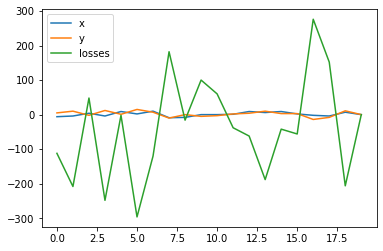

In [12]:
result_df.plot()

### **-HyperOpt를 이용한 xgboost 하이퍼 파라미터 최적화**

#### 주의사항
#### 1. 특정 하이퍼 파라미터들은 정숫값만 입력받아야하는데 hyperopt는 입력값, 반환값 모두 실수형이라 type 변환 필요
#### 2. 최댓값을 최적화 하는 경우엔 -1곱해줘야 함

In [13]:
# 아래 코드는 이전에 수록된 코드라 책에는 싣지 않았습니다. 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [14]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

##### 1. 검색공간 설정

In [15]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로 (quniform)
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색. (uniform)
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), ## 정수형 하이퍼 파라미터 => quniform 사용
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1), ## 정수형 하이퍼 파라미터 => quniform 사용
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

##### 2. 목적함수 설정

In [16]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

####  fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
#### XGBClassifier의 정수형 하이퍼 파라미터는 **정수형 변환을 해줘야 함.**
#### 따라서 하이퍼파라미터가 받는 숫자가 정수형인지, 실수형인지 살펴볼 것
#### **정확도는 높을수록 더 좋은 수치임. -1x정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환**

In [17]:
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']), #int붙이기
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3) #교차검증표 함수 사용
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK} #-1곱하기,

##### 3. fmin()함수를 이용해 최적화 함수 찾기

In [18]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func, #목적함수
            space=xgb_search_space, #하이퍼파라미터 검생공간
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, #rstate=np.random.default_rng(seed=0)
            )
print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61trial/s, best loss: -0.9714476588823051]
best: {'colsample_bytree': 0.500801678525394, 'learning_rate': 0.19789859485936773, 'max_depth': 18.0, 'min_child_weight': 2.0}


#### 정수형 파라미터인 max_depth, min_child_weight가 실수형으로 도출됨 -> 앞에서 말한 int붙인건 3.2313 이런값 안나오게 하기 위함
#### 형변환 필요

In [20]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.5008, learning_rate:0.1979, max_depth:18, min_child_weight:2


##### 4. 획득한 최적의 하이퍼 파라미터를 이용하여 XGBoost의 인자로 입력

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [22]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.53619	validation_1-logloss:0.58435
[1]	validation_0-logloss:0.42801	validation_1-logloss:0.50457
[2]	validation_0-logloss:0.34833	validation_1-logloss:0.44614
[3]	validation_0-logloss:0.28906	validation_1-logloss:0.40997
[4]	validation_0-logloss:0.24191	validation_1-logloss:0.38158
[5]	validation_0-logloss:0.20629	validation_1-logloss:0.36414
[6]	validation_0-logloss:0.17610	validation_1-logloss:0.34030
[7]	validation_0-logloss:0.15290	validation_1-logloss:0.32754
[8]	validation_0-logloss:0.13387	validation_1-logloss:0.31121
[9]	validation_0-logloss:0.11656	validation_1-logloss:0.30058
[10]	validation_0-logloss:0.10280	validation_1-logloss:0.29384
[11]	validation_0-logloss:0.09049	validation_1-logloss:0.27989
[12]	validation_0-logloss:0.08218	validation_1-logloss:0.27734
[13]	validation_0-logloss:0.07291	validation_1-logloss:0.26603
[14]	validation_0-logloss:0.06740	validation_1-logloss:0.26731
[15]	validation_0-logloss:0.06271	validation_1-logloss:0.26637
[1